# R4 on ISIC 2019

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
import abstract_gradient_training as agt
from abstract_gradient_training import certified_training_utils as ct_utils
from models.deepmind import DeepMindSmall, DeepMindAugmented
from models.robust_regularizer import input_gradient_interval_regularizer
from datasets import isic

# Get the dataloaders 

In [2]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
batch_size = 100

cuda:1


In [ ]:
# isic_save_path = "/vol/bitbucket/mg2720/isic/isic.pt"
# [isic_input_tensors, isic_labels] = torch.load(isic_save_path, mmap=True)
DATA_ROOT = "/vol/bitbucket/mg2720/isic/isic_train_new"
METADATA_FILE = "/vol/bitbucket/mg2720/isic/isic_train_new/metadata.csv"
MASKS_ROOT = "/vol/bitbucket/mg2720/isic/segmentation"

isic_train = isic.ISICDataset(DATA_ROOT, METADATA_FILE, is_train=True, masks_root=MASKS_ROOT)
isic_test = isic.ISICDataset(DATA_ROOT, METADATA_FILE, is_train=False)
img, lbl, mask = isic_train[1]
print(img.shape, lbl, mask.shape)
print(len(isic_train), len(isic_test))

torch.Size([3, 299, 299]) tensor(1) torch.Size([299, 299])
13332 4444


tensor([0.])


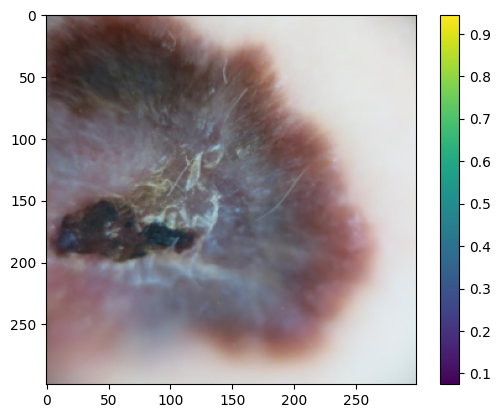

In [4]:
plt.imshow(img.permute(1, 2, 0).squeeze().numpy())
# plt.imshow(mask.squeeze().numpy())
plt.colorbar()
print(mask.unique())

In [5]:
dl_train = isic.get_loader_from_dataset(isic_train, batch_size=batch_size, shuffle=False)
dl_test = isic.get_loader_from_dataset(isic_test, batch_size=batch_size, shuffle=False)

In [17]:
def train_model_with(n_epochs, model, learning_rate, criterion, epsilon, mlx_method, k, has_conv):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # pre-train the model
    progress_bar = tqdm.trange(n_epochs, desc="Epoch", )
    for _ in progress_bar:
        for i, (x, u, m) in enumerate(dl_train):
            # Forward pass
            u, x, m = u.to(device).float(), x.to(device), m.to(device)

            # output is [batch_size, 1], u is [bach_size] but BCELoss does not support different target and source sizes
            output = model(x).squeeze()
            # For std, we will waste some time doing the bounds, but at least it is consistent across methods
            inp_grad_reg = input_gradient_interval_regularizer(
                model, x, u, "binary_cross_entropy", epsilon, 0.0, regularizer_type=mlx_method, batch_masks=m, has_conv=has_conv
            )
            if mlx_method == "std":
                assert inp_grad_reg == 0
            loss = criterion(output, u) + k * inp_grad_reg
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                progress_bar.set_postfix(loss=loss.item())

In [32]:
def test_model_acc(model):
    # evaluate the pre-trained model
    # here, param_n, param_l, param_u are the parameters of the model and l and u are the same (we did not poison)
    all_acc = 0
    for test_batch, test_labels in dl_test:
        # Just do a simple forward and compare the output to the labels
        test_batch, test_labels = test_batch.to(device), test_labels.to(device)
        output = model(test_batch).squeeze()
        correct = ((output > 0.5) == (test_labels)).sum().item()
        all_acc += correct
    all_acc /= len(dl_test.dataset)
    print("--- Pre-trained model accuracy ---")
    print(f"Nominal = {all_acc:.2g}")

In [19]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx, has_conv):
    channel_to_view = 1
    batch_input, batch_labels = batch_input.to(device), batch_labels.to(device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "binary_cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4", batch_masks=batch_mask, has_conv=has_conv
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    print(f"input lower bound shape: {dx_l.shape}")
    print(f"input upper bound shape: {dx_u.shape}")
    print(f"input gradient shape: {dx_n.shape}")
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    lesion = batch_input[elem_idx].permute(1, 2, 0).cpu().numpy()
    mask = batch_mask[elem_idx].cpu().numpy()
    # choose only 1 channel gradient to view, because with 3 channels, the bounds do not represent rgb values
    dx_l_view, dx_u_view, dx_n_view = dx_l[elem_idx][channel_to_view].squeeze(), dx_u[elem_idx][channel_to_view].squeeze(), dx_n[elem_idx][channel_to_view].squeeze()
    ax[0][0].imshow(lesion)
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(mask, cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l_view.cpu().detach().numpy())
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u_view.cpu().detach().numpy())
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_u, ax=ax[1][1])
    im_dx_n = ax[2][0].imshow(dx_n_view.cpu().detach().numpy())
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [30]:
# define model, dataset and optimizer
num_epochs = 1
lr = 0.01
restarts = 3
epsilon = 0.01
# k is a coefficient for the regularization term
k = 0.2
model = DeepMindAugmented(3, 1)
criterion = torch.nn.BCELoss()
model = model.to(device)
print(model)

DeepMindAugmented(
  (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(4, 4))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=43808, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=1, bias=True)
  (8): Sigmoid()
)


28
Batch input shape: torch.Size([100, 3, 299, 299]), batch mask shape: torch.Size([100, 299, 299])
input lower bound shape: torch.Size([100, 3, 299, 299])
input upper bound shape: torch.Size([100, 3, 299, 299])
input gradient shape: torch.Size([100, 3, 299, 299])


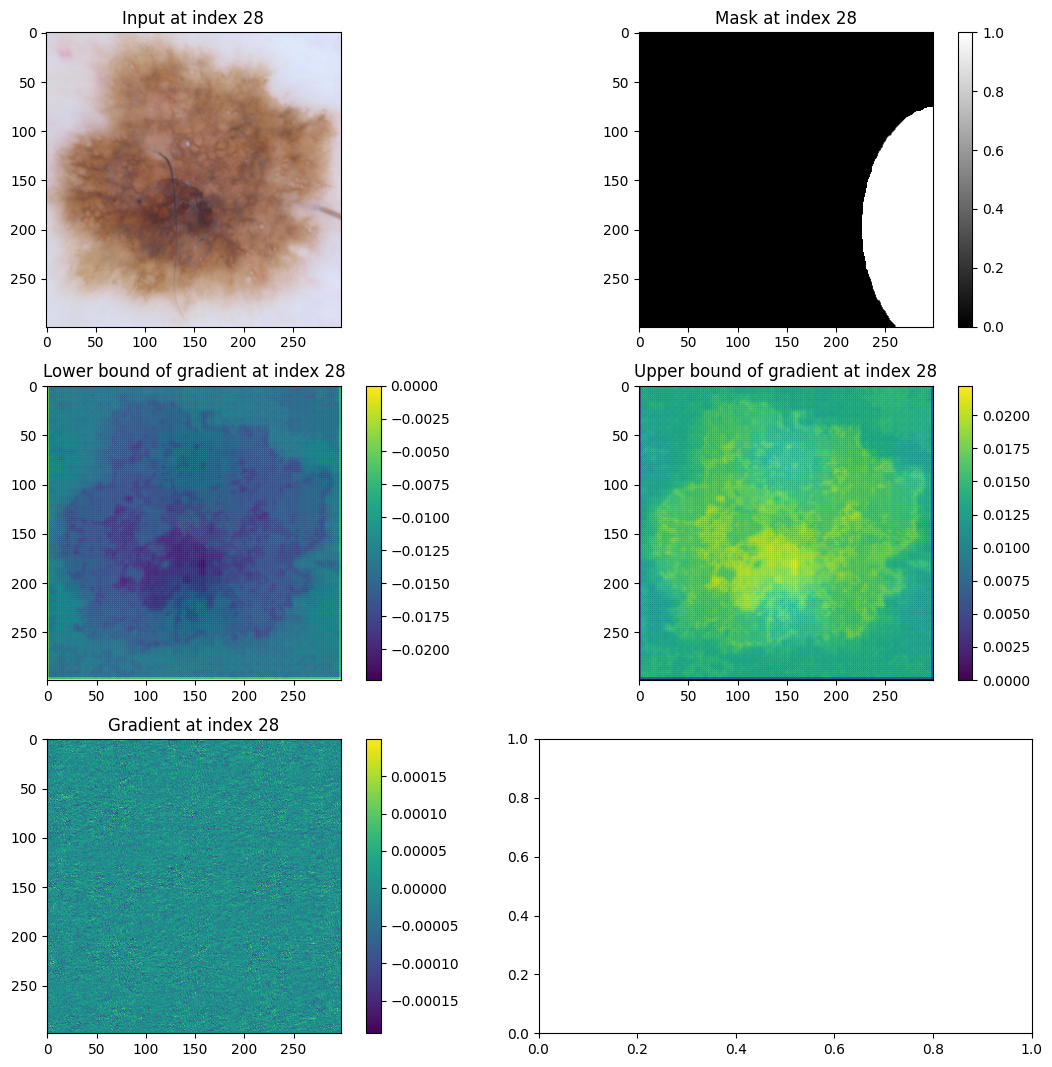

In [21]:
idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
print(idx_to_visualize)
init_batch_train_with_masks = next(iter(dl_train))
print(f"Batch input shape: {init_batch_train_with_masks[0].shape}, batch mask shape: {init_batch_train_with_masks[2].shape}")
visualize_gradient(model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)

## Experiments 

In [22]:
DELTA_INPUT_ROBUSTNESS_PARAM = 0.1

In [23]:
def test_delta_input_robustness(model):
    # The model needs to be delta input robust only in the irrelevant features
    num_robust = 0
    for test_batch, test_labels, test_masks in dl_test:
        test_batch, test_labels, test_masks = test_batch.to(device), test_labels.to(device), test_masks.to(device)
        test_batch = test_batch.flatten(start_dim=1)
        test_masks = test_masks.flatten(start_dim=1)
        # The MLX method does not really matter, as we return the grads
        grad_bounds = input_gradient_interval_regularizer(model, test_batch, test_labels, "binary_cross_entropy", epsilon, 0.0, return_grads=True, batch_masks=test_masks)
        d_l, d_u = grad_bounds[1]
        d_l, d_u = d_l.flatten(start_dim=1), d_u.flatten(start_dim=1)
        d_l, d_u = d_l * test_masks, d_u * test_masks
        abs_diff = torch.abs(d_l - d_u)
        # [batch_size, input_dim]
        robust_grad_inputs = torch.where(abs_diff <= DELTA_INPUT_ROBUSTNESS_PARAM, 1, 0).bool()
        # [batch_size]
        is_robust_grad = robust_grad_inputs.all(dim=-1)
        num_robust += is_robust_grad.sum().item()
    num_robust /= len(dl_test.dataset)
    print("--- Pre-trained model delta input robustness ---")
    print(f"Delta Input Robustness = {num_robust:.2g}")


### Standard Training

In [33]:
mlx_method = "std"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DeepMindAugmented(3, 1).to(device)

    print(f"========== Training model with method {mlx_method} restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, mlx_method, k, has_conv=True)
    test_model_acc(curr_model)
    # test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)

========== Training model with method std restart 0 ==========
Matched 89 in current batch of 100
Matched 88 in current batch of 100
Matched 91 in current batch of 100
Matched 94 in current batch of 100
Matched 88 in current batch of 100
Matched 89 in current batch of 100
Matched 87 in current batch of 100
Matched 91 in current batch of 100
Matched 89 in current batch of 100
Matched 90 in current batch of 100
Matched 84 in current batch of 100
Matched 89 in current batch of 100
Matched 85 in current batch of 100
Matched 89 in current batch of 100
Matched 92 in current batch of 100
Matched 93 in current batch of 100
Matched 100 in current batch of 100
Matched 86 in current batch of 100
Matched 70 in current batch of 100
Matched 81 in current batch of 100
Matched 86 in current batch of 100
Matched 85 in current batch of 100
Matched 53 in current batch of 100
Matched 53 in current batch of 100
Matched 68 in current batch of 100
Matched 61 in current batch of 100
Matched 82 in current batc

TypeError: visualize_gradient() missing 1 required positional argument: 'has_conv'

### RRR Training

========== Training model with method r3, restart 0 ==========


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [00:25<00:00,  2.53s/it, loss=1.48]


--- Pre-trained model accuracy ---
Nominal = 0.68
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9
========== Training model with method r3, restart 1 ==========


Epoch: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it, loss=1.47]


--- Pre-trained model accuracy ---
Nominal = 0.69
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9
========== Training model with method r3, restart 2 ==========


Epoch: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it, loss=1.48]


--- Pre-trained model accuracy ---
Nominal = 0.7
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9


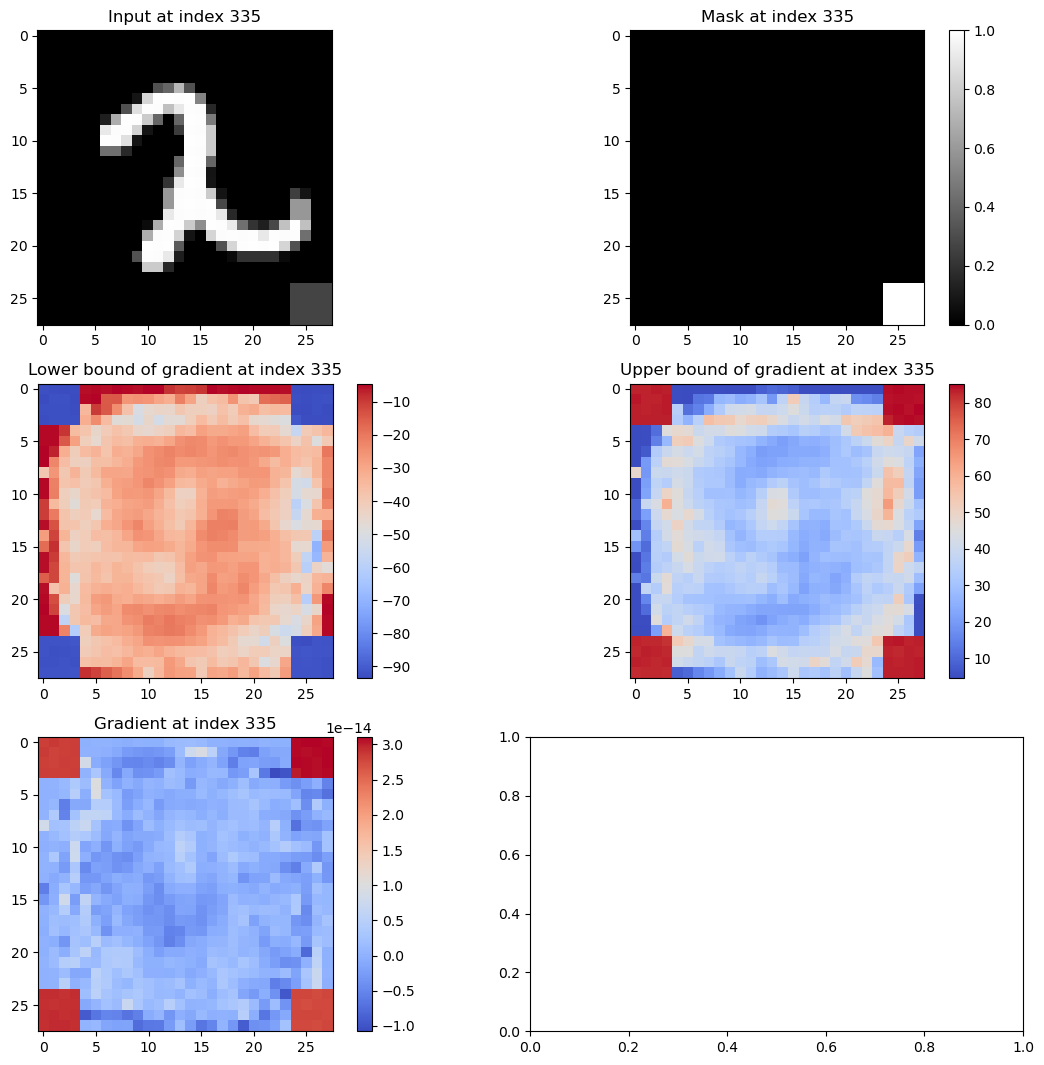

In [71]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DeepMindAugmented(3, 1).to(device)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, rrr_method, 1e-2, has_conv=True)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)

========== Training model with method R4, restart 0 ==========


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it, loss=1.48]


--- Pre-trained model accuracy ---
Nominal = 0.97
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9
========== Training model with method R4, restart 1 ==========


Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it, loss=1.48]


--- Pre-trained model accuracy ---
Nominal = 0.98
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9
========== Training model with method R4, restart 2 ==========


Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it, loss=1.48]


--- Pre-trained model accuracy ---
Nominal = 0.98
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.9


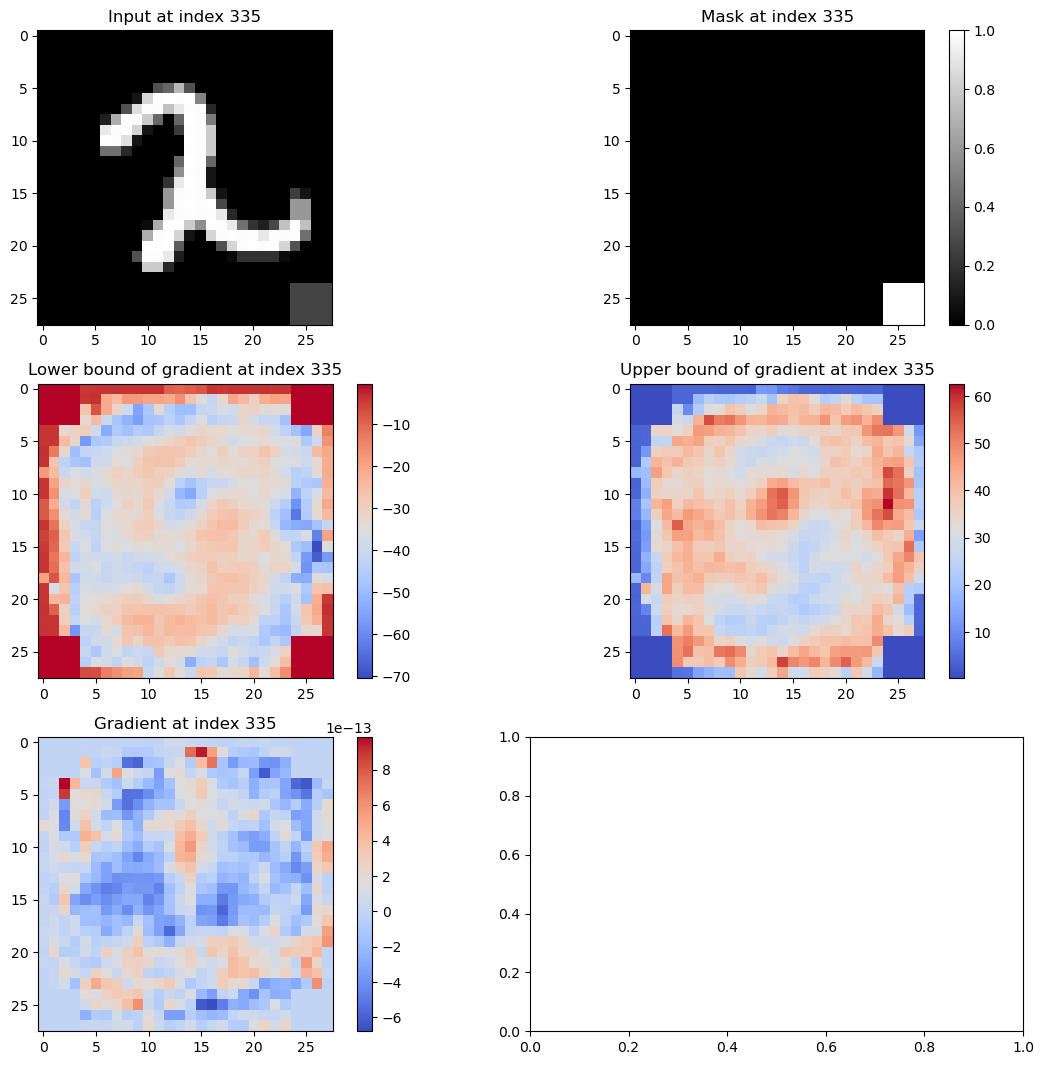

In [62]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DeepMindAugmented(3, 1).to(device)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, has_conv=True)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize, has_conv=True)